In [1]:
import os
import sys
## Emily's path to misloc package
# module_path = os.path.abspath(os.path.join('..', '..'))
## Harrison's path to misloc package
module_path = os.path.abspath(os.path.join(
    '/Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
    ))
sys.path.append(module_path)

## Emily's package name
# from misloc_package.parameterize import displaced_osc_model as dom
## Harrison's package name
from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

Plot parameters

In [3]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


Load data 

In [4]:
path_to_mol_data = os.path.join('..', 'data')

emily_data_flip = np.loadtxt(
    os.path.join(path_to_mol_data, 'H-1-slow-pf.csv'), 
#     skiprows=0, 
    delimiter=','
    )
emily_data = emily_data_flip[::-1]

## Some useful functions
def norm_spec(spec):
    return spec/spec.max()

# def nm_to_ev_correct(spec):
#     return spec/(1240/thermo_fisher_dye_data.T[0])**5.

In [5]:
def int_norm(y, x=emily_data.T[0]):
    return y / int.trapz(y, x)

In [6]:
def model_from_params(
    params, 
    num_modes, 
    temp
    ):
    return dom.anda_mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+1*num_modes: 2+2*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=[params[1]]*num_modes,
        T=temp)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] hbar_gamma: damping rate from 
                solvent or etc.
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
    [
        hbar_omegas, 
        data, 
        num_modes, 
        t_bound, 
        t_points, 
        norm,
        temp
        ] = args

    model_instance = model_from_params(params, num_modes, temp=temp)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,
        )

    if (norm is 'integral') or (norm is 'Integral') or (norm is 'int'):
        ## Normalize model and data
        model = int_norm(model, hbar_omegas)
    elif norm is 'magnitude':
        ## Normalize model and data
        model = model / np.max(model)
        data = data / np.max(data)

    return (model - data) * model 

In [7]:
def print_parameters_w_names(params):
    """Only works for 2 modes"""
    print(f'hbar_omega_eg_0 = {params[0]}')
    print(f'hbar_gamma = {params[1]}')
    print(f'hbar_omega_0 = {params[2:4]}')
    print(f'script_d = {params[4:6]}')

## Find a 'physical' looking guess 

In [8]:
## Define initial guesses
ini_hbar_omega_eg_0 = 2.6
ini_script_d = [1.75, 2.5]
ini_hbar_omega_0 = [0.132, .018]
ini_hbar_gamma = .017
T = 294

t_bound = 250
t_points = 700

## New 06/02
## Sort initial guesses into proper order for fit func
fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_hbar_gamma,
    *ini_hbar_omega_0,
    *ini_script_d,
    ])

ini_guess_inst = model_from_params(fit_ini_guess, num_modes=2, temp=T)


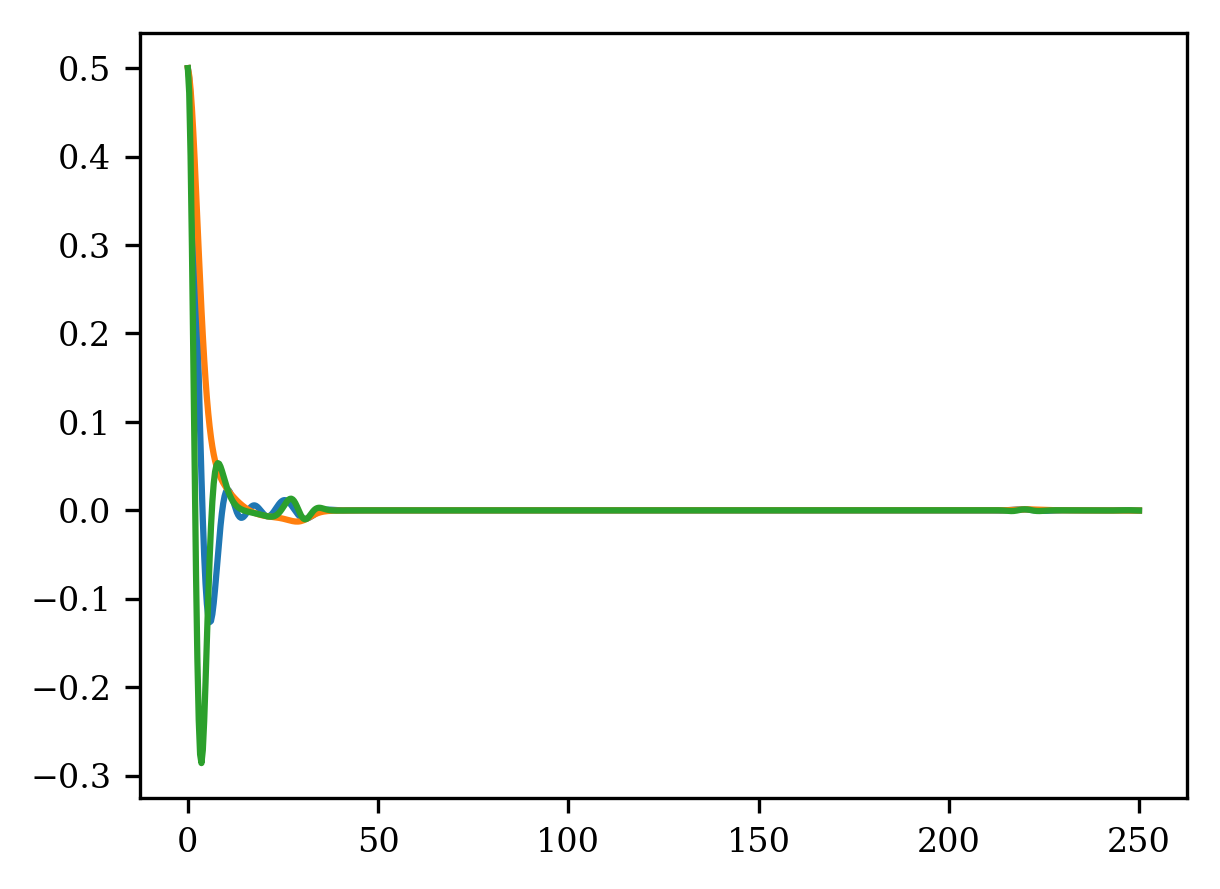

In [9]:
## Plot integrand
ts, ini_2_mode_integrands = ini_guess_inst.emission_lineshape(
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 3)/hbar,
#     mode_idx,
    t_bound = t_bound,
    t_points = t_points, 
    return_integrand=True)

for integ in ini_2_mode_integrands:
    plt.plot(ts, integ)
    

(0, 100)

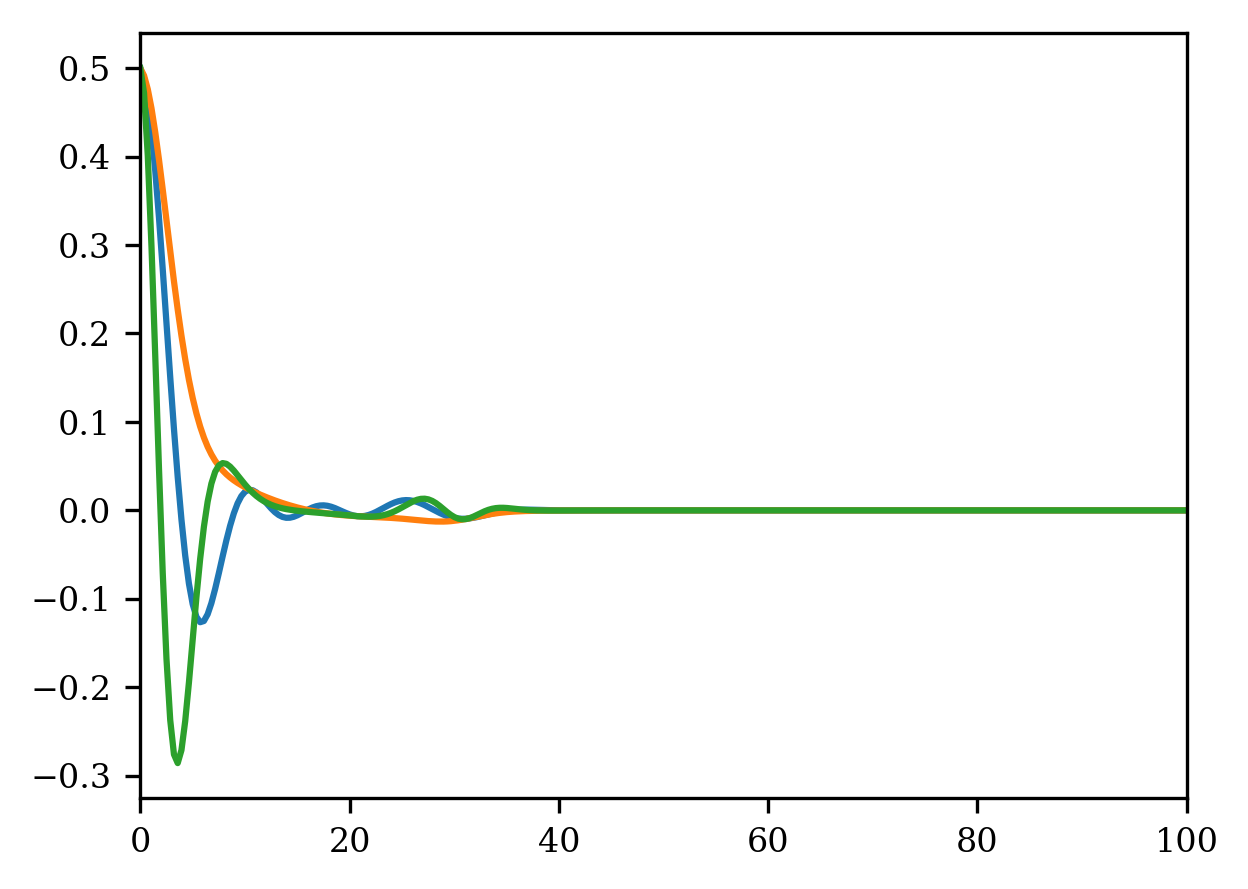

In [10]:
for integ in ini_2_mode_integrands:
    plt.plot(ts, integ)
    
plt.xlim([0, 100])

In [11]:
## ini. guess lineshape
ini_2_mode = ini_guess_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = t_bound,
    t_points = t_points)

##
ini_1st_mode = ini_guess_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = t_bound,
    t_points = t_points)

ini_2nd_mode = ini_guess_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = t_bound,
    t_points = t_points)

Text(0, 0.5, 'Normalized Emission Probability')

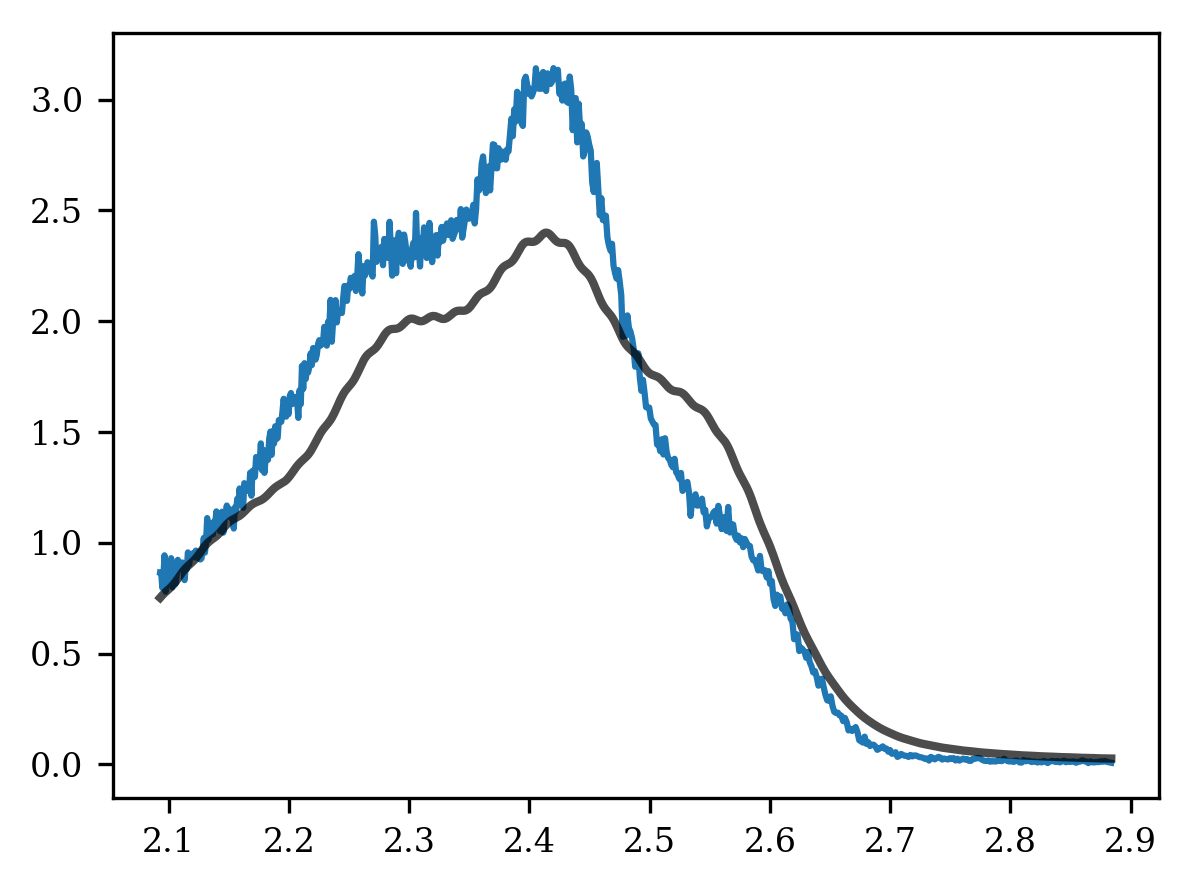

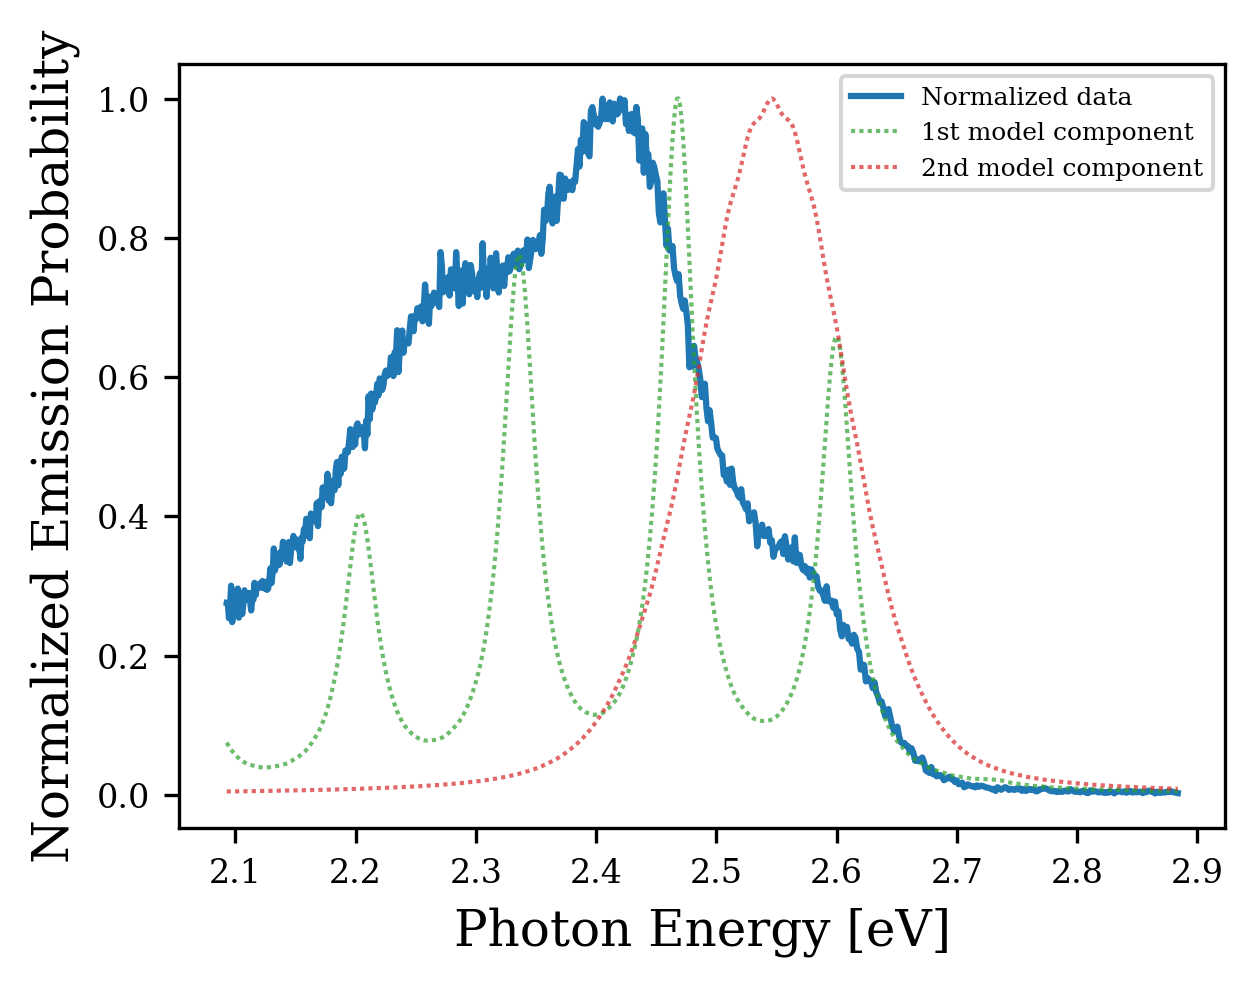

In [12]:
plt.figure()
plt.plot(emily_data.T[0], (emily_data.T[1]), label='data')
plt.plot(emily_data.T[0], (ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')

plt.figure()
plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='Normalized data')
# plt.plot(emily_data.T[0], norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(ini_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(ini_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')

plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

Let's first make sure the anharmomnic implementation can reproduce this harmonic result

In [14]:
basis_size = 20

In [15]:
mm_lam_g_0 = np.array([0, 0, 0])
mm_lam_g_1 = np.array([0, 0, 0])
mm_lam_e_0 = dom.displaced_lambdas(np.array([0, 0, 0]), ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(np.array([0, 0, 0]), ini_script_d[1])

mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
hw_domain = (
    np.linspace(emily_data.T[0].min(), emily_data.T[0].max(), 100)
    - ini_hbar_omega_eg_0
    )
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [16]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

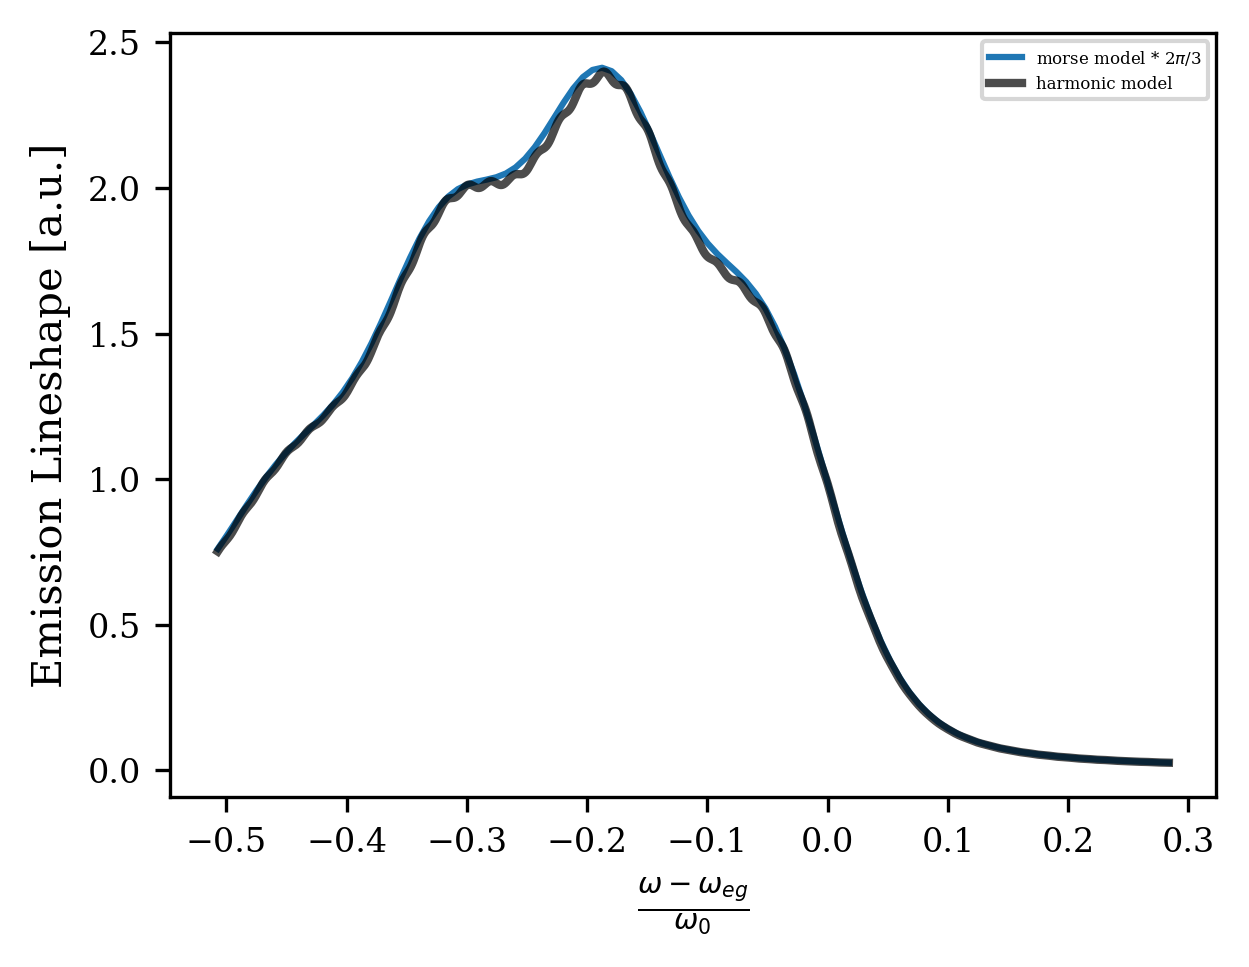

In [17]:
plt.plot(hw_domain, (mm_lineshape)*2*np.pi/3, label='morse model * 2$\pi$/3')
# plt.plot(hw_domain, mm_lineshape_m0, ls='--')
# plt.plot(hw_domain, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, (ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

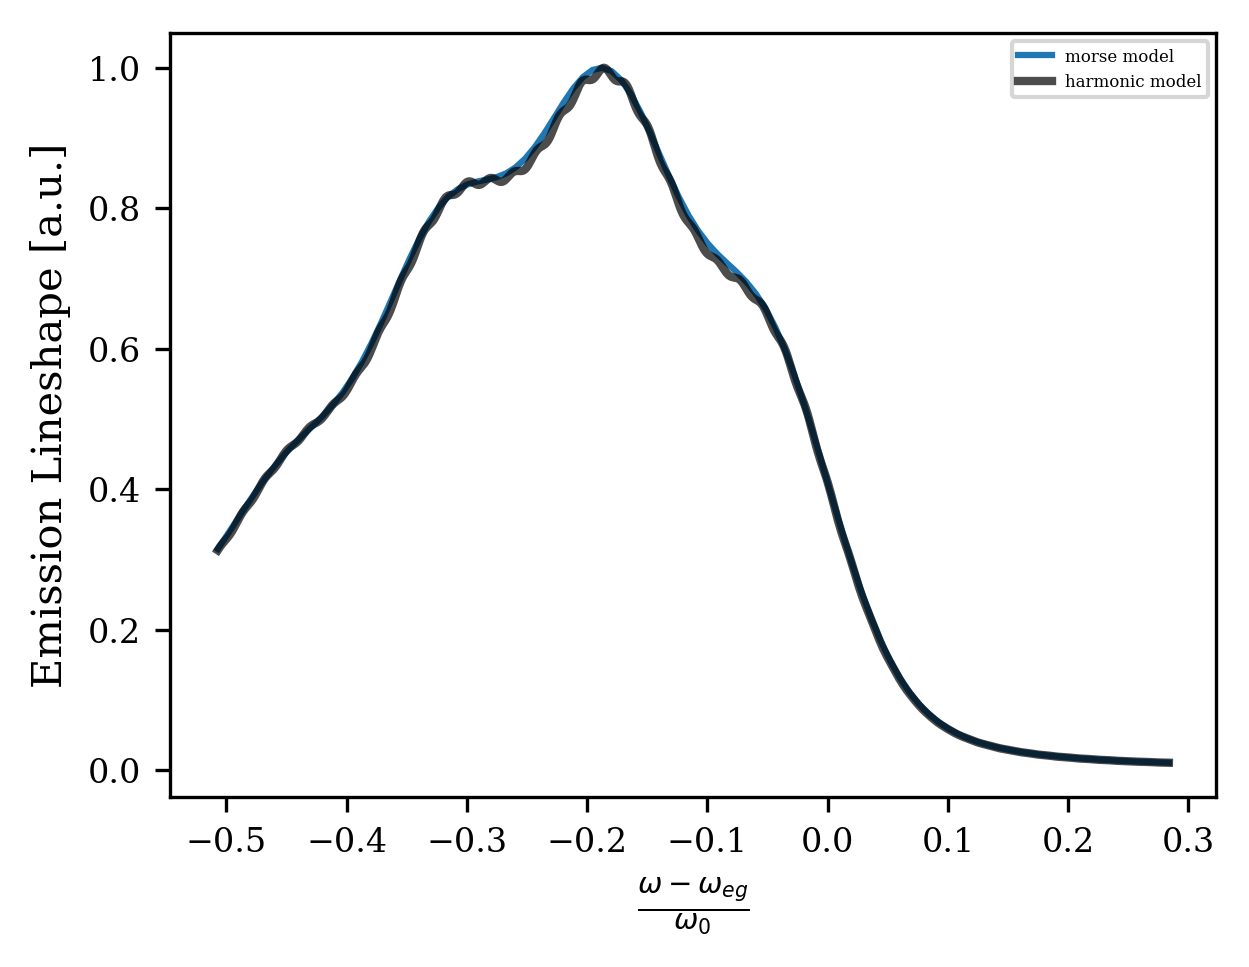

In [18]:
plt.plot(hw_domain, norm_spec(mm_lineshape), label='morse model')
# plt.plot(hw_domain, mm_lineshape_m0, ls='--')
# plt.plot(hw_domain, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

## What does anharmonicity do to the high energy mode?

In [19]:
def lambda_generator_Morse(a, D):
    """ This is a function that returns the lambda prefactors for a Morse
        Potential expanded to 12th order. 
        
        Returns:
        -------
            lambdas: an array of perterbed polynomial prefactors determined from Mathematica
        """
    lambdas = np.array([
        0, 
        0,
        ## Make sure to subtract .5 from harmonic term to accound for the 
        ## unperterbed potential 
        a**2. * D - 0.5,
        -a**3. * D,
        (7/12) * a**4 * D,
        (-1/4) * a**5 * D,
        (31/360) * a**6 * D,
        (-1/40) * a**7 * D,
        (127/20160) * a**8 * D,
        (-17/12096) * a**9 * D,
        (73/259200) * a**10 * D,
        (-31/604800) * a**11 * D,
        (2047/239500800) * a**12 * D,
        ])

    
    return lambdas

In [20]:
## Energy spacing of unperterbed vibration
hbarw0_mor = 1
# D = hbarw0_mor
D = 60
alpha = 0.0913
gamma=.18/hbar

mor_lam_g = lambda_generator_Morse(alpha, D)

## Build excited state lambdas from ground state and displacement
mor_lam_e = dom.displaced_lambdas(mor_lam_g, d=1.6)

## Assign the temperature
T_mor = 294

## Number of oscillator states used for representation of general 
## potential energy eigenstates
basis_size = 20
## Define Vibrational Hamiltonians in units of energy (by multiplying by 
## the unperturbed vibrational energy spacing).
## -----

Test to see that the surface looks right

In [21]:
pot_xs = np.linspace(-7, 10, 100)
Vg_of_x = dom.poly_from_lambdas(pot_xs, mor_lam_g)
Vh_of_x = dom.poly_from_lambdas(pot_xs, np.array([0,0,0]))


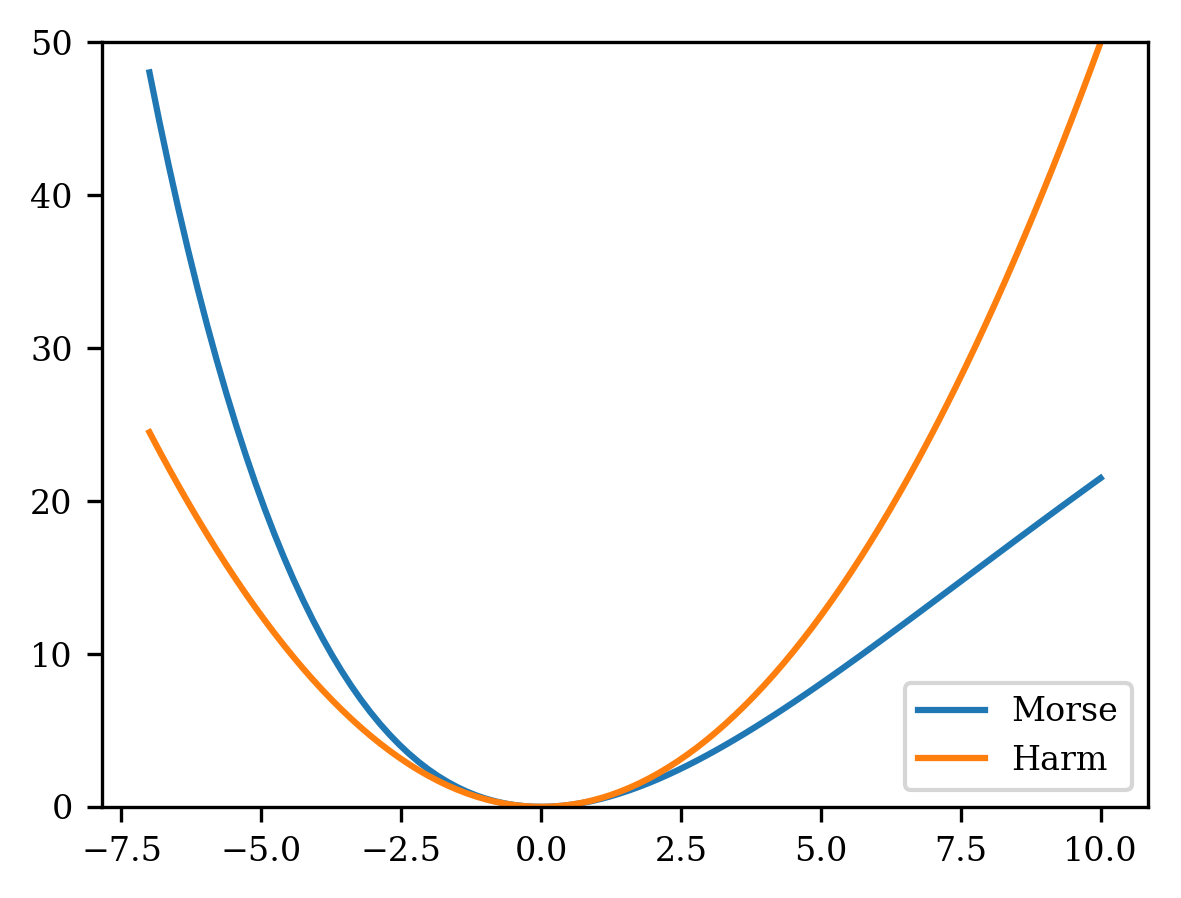

In [22]:
plt.plot(pot_xs, Vg_of_x, label='Morse')
plt.plot(pot_xs, Vh_of_x, label='Harm')
plt.ylim([0,50])
plt.legend()

In [23]:
lambda_generator_Morse(0, D)

array([ 0. ,  0. , -0.5, -0. ,  0. , -0. ,  0. , -0. ,  0. , -0. ,  0. ,
       -0. ,  0. ])

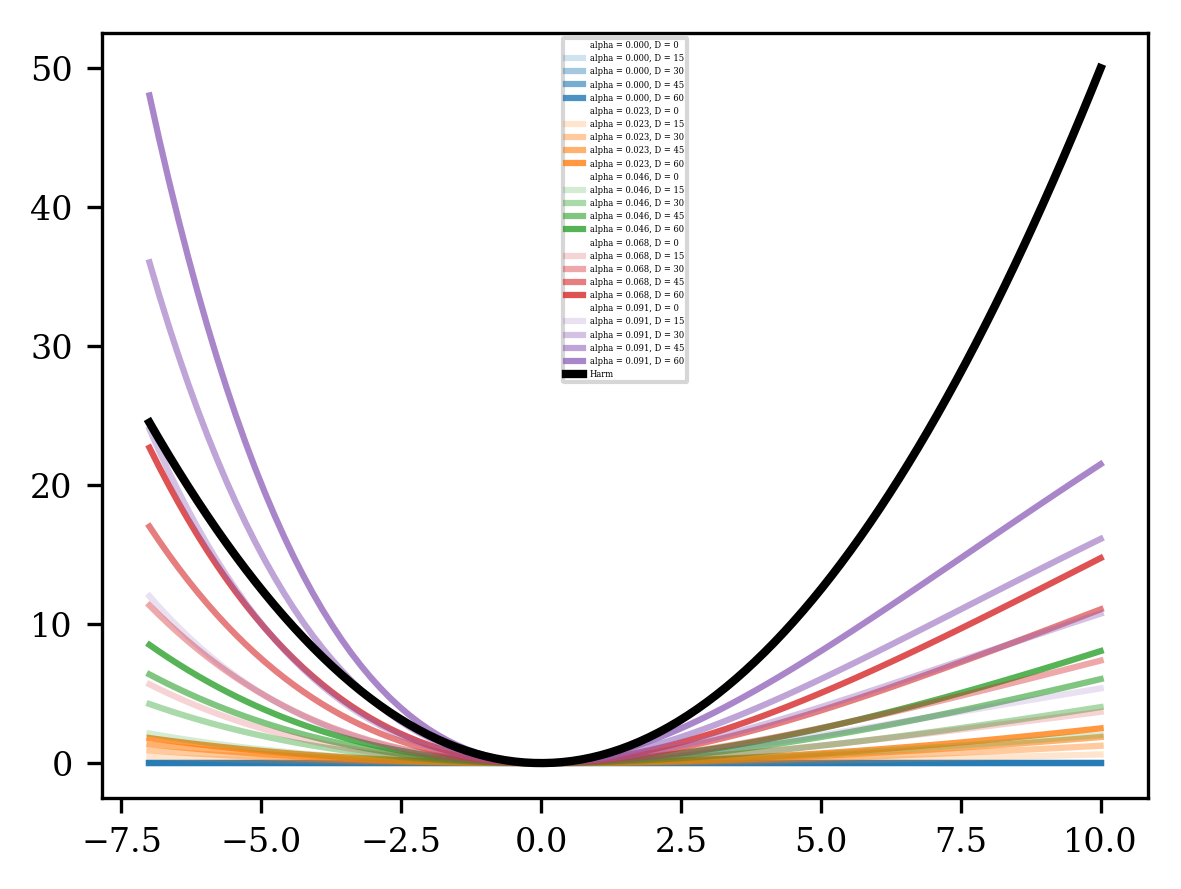

In [24]:
for i, a in enumerate(np.linspace(0, alpha, 5)):
    for j, d in enumerate(np.linspace(0, D, 5)):
        plt.plot(
            pot_xs, 
            dom.poly_from_lambdas(pot_xs, lambda_generator_Morse(a, d)),
            label=f"alpha = {a:.3f}, D = {round(d):.0f}",
            alpha=j/5,
            c=mpl.cm.tab10(i/10) 
            )
plt.plot(pot_xs, Vh_of_x, label='Harm', c='k', lw=2)
plt.legend(fontsize=2)
        

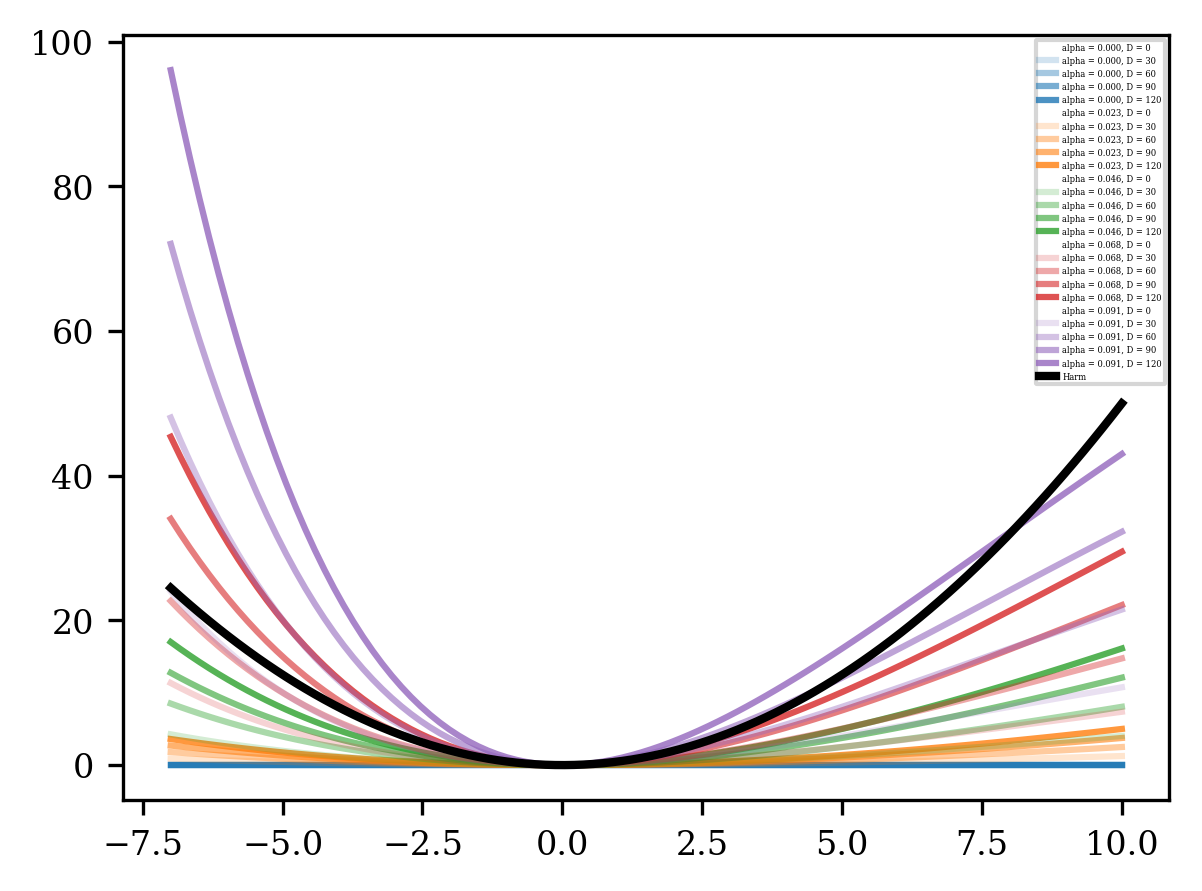

In [25]:
for i, a in enumerate(np.linspace(0, alpha, 5)):
    for j, d in enumerate(np.linspace(0, D*2, 5)):
        plt.plot(
            pot_xs, 
            dom.poly_from_lambdas(pot_xs, lambda_generator_Morse(a, d)),
            label=f"alpha = {a:.3f}, D = {round(d):.0f}",
            alpha=j/5,
            c=mpl.cm.tab10(i/10) 
            )
plt.plot(pot_xs, Vh_of_x, label='Harm', c='k', lw=2)
plt.legend(fontsize=2)
        

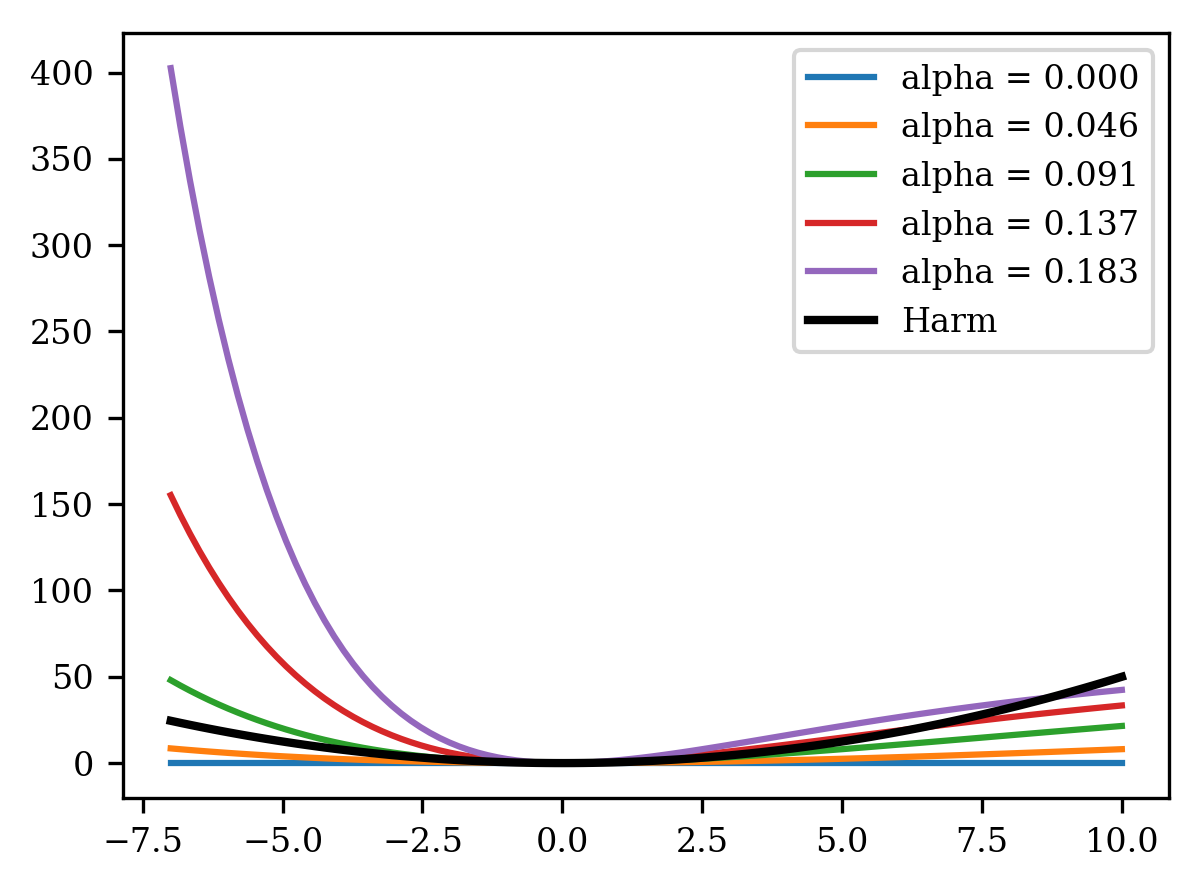

In [26]:
for i, a in enumerate(np.linspace(0, alpha*2, 5)):
    plt.plot(
        pot_xs, 
        dom.poly_from_lambdas(pot_xs, lambda_generator_Morse(a, D)),
        label=f"alpha = {a:.3f}",
        )
plt.plot(pot_xs, Vh_of_x, label='Harm', c='k', lw=2)
plt.legend()
        

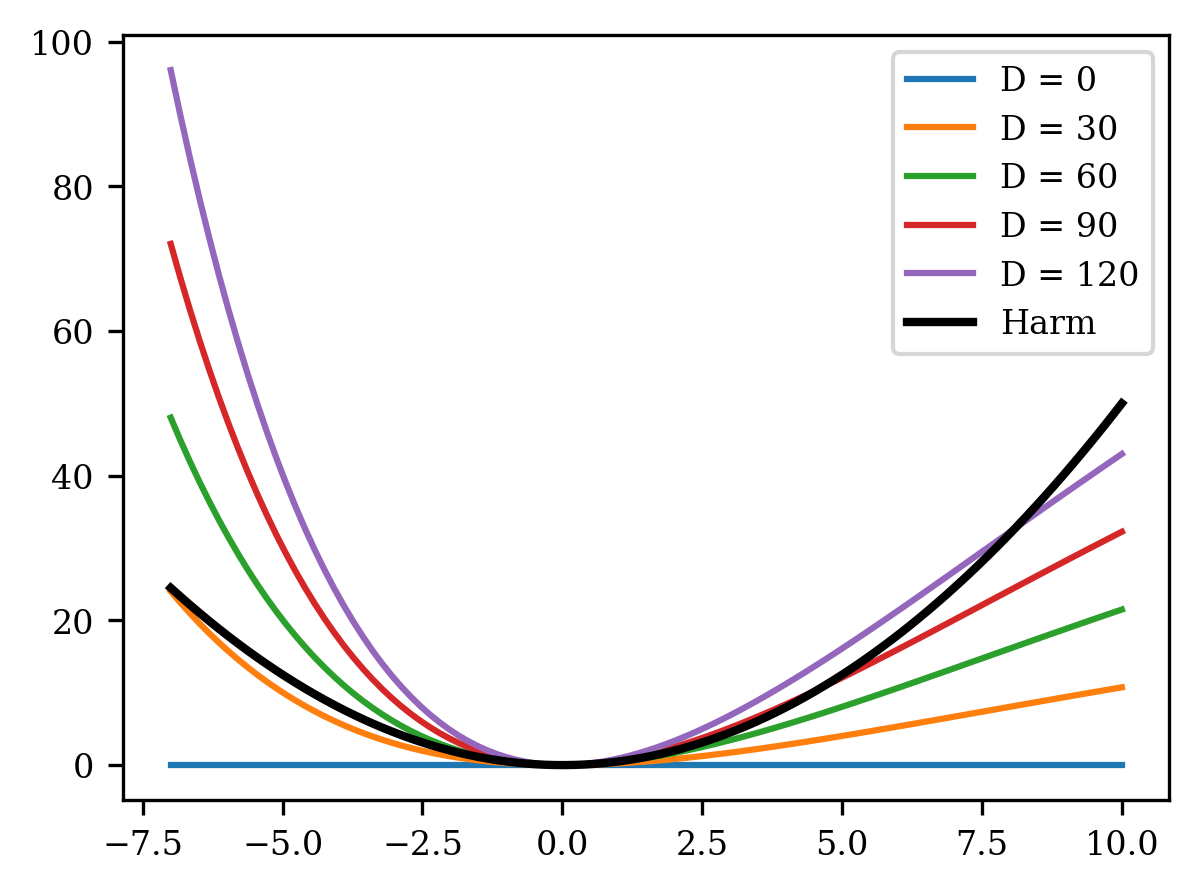

In [27]:
for i, d in enumerate(np.linspace(0, D*2, 5)):
    plt.plot(
        pot_xs, 
        dom.poly_from_lambdas(pot_xs, lambda_generator_Morse(alpha, d)),
        label=f"D = {d:.0f}",
        )
plt.plot(pot_xs, Vh_of_x, label='Harm', c='k', lw=2)
plt.legend()

I don't know lets just try it

In [28]:
# ## Define initial guesses
# ini_hbar_omega_eg_0 = 2.6
# ini_script_d = [1.75, 2.5]
# ini_hbar_omega_0 = [0.132, .018]
# ini_hbar_gamma = .013
# T = 294

# t_bound = 2500
# t_points = 10000

In [29]:
alpha_test = 0.091
depth_test = 45
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [30]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [31]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

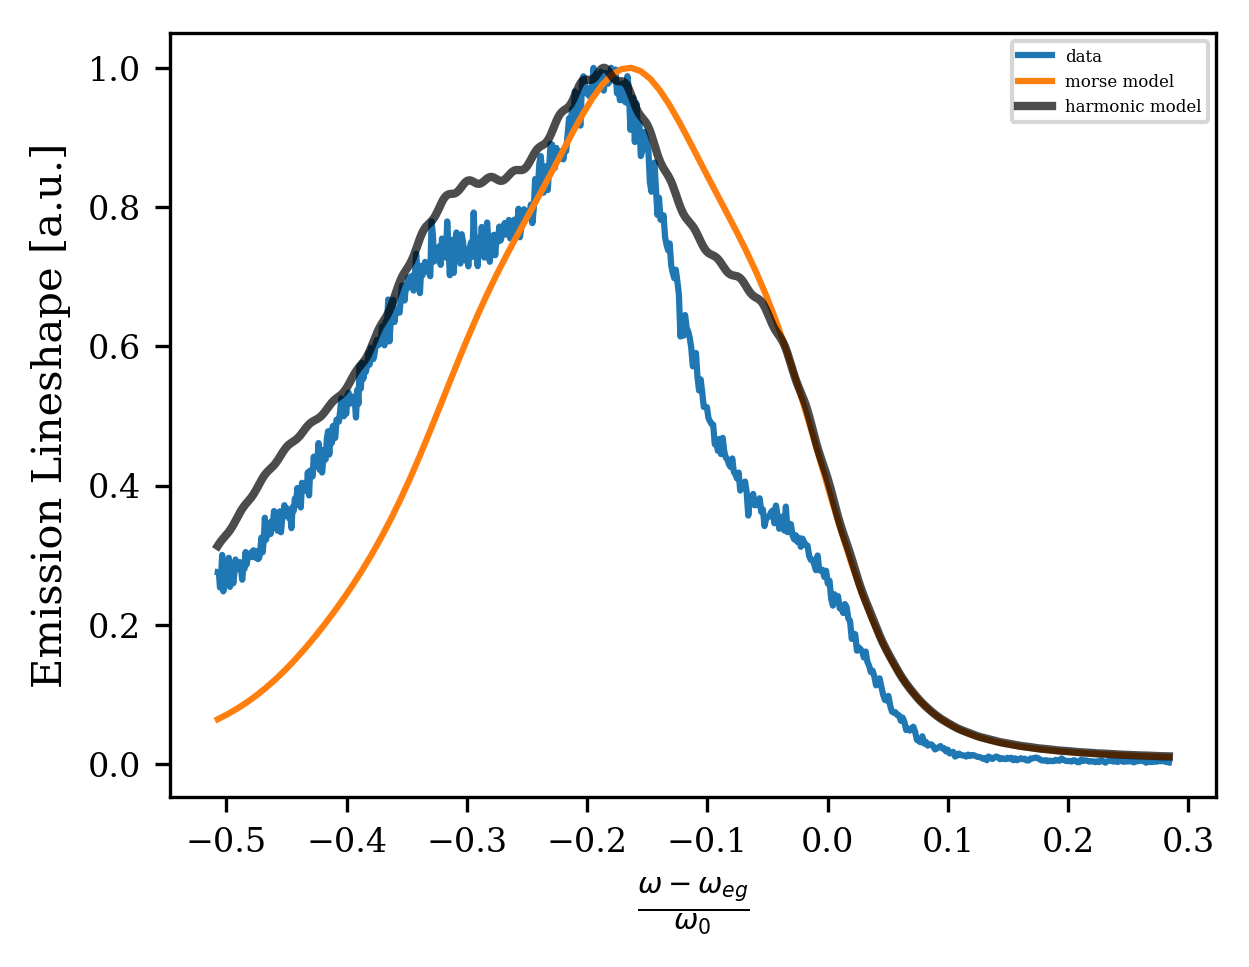

In [32]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

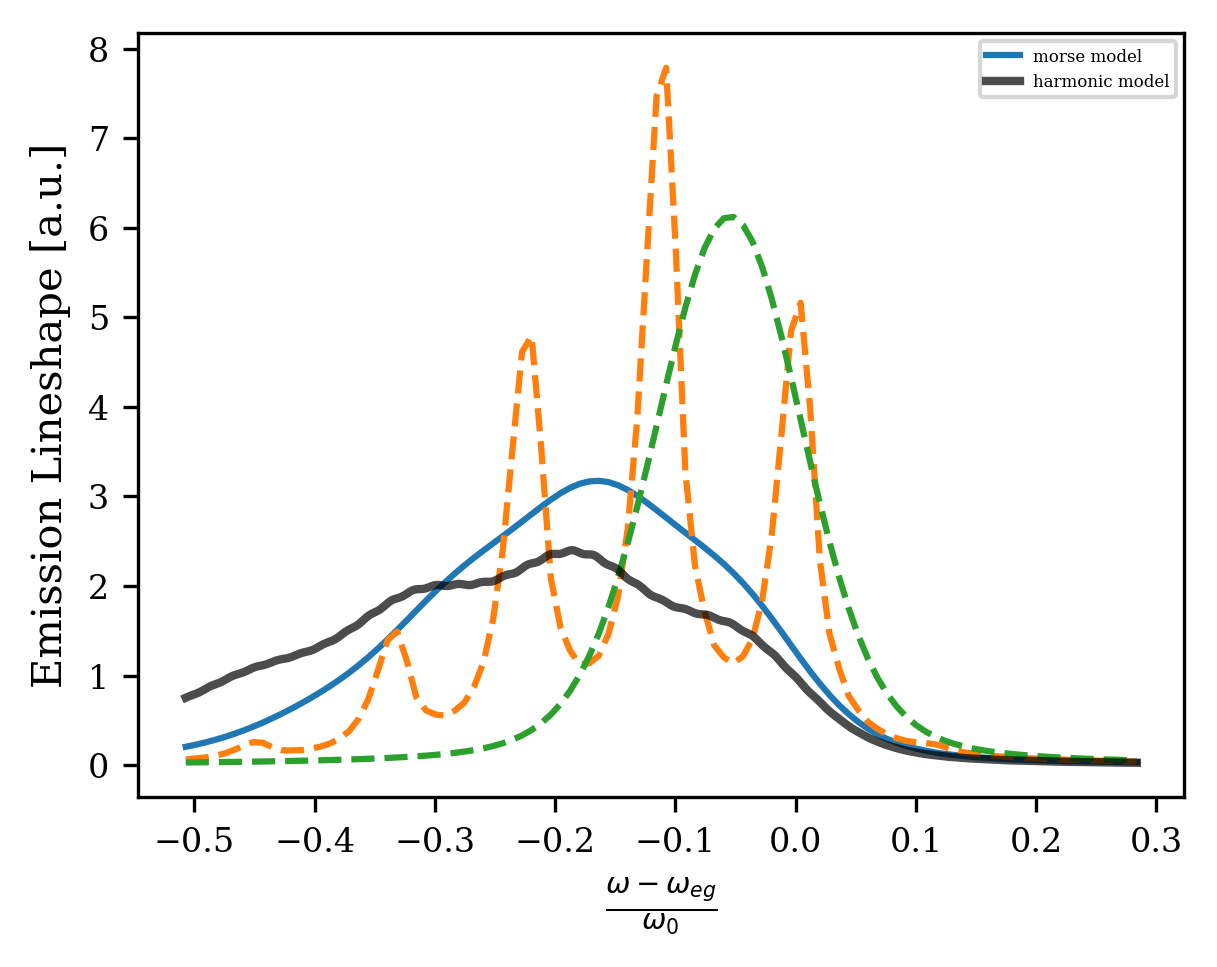

In [33]:
plt.plot(hw_domain, mm_lineshape*2*np.pi/3, label='morse model')
plt.plot(hw_domain, mm_lineshape_m0*2*np.pi/3, ls='--')
plt.plot(hw_domain, mm_lineshape_m1*2*np.pi/3, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, (ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

In [60]:
alpha_test = 0.091
depth_test = 45*2
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [35]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [36]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

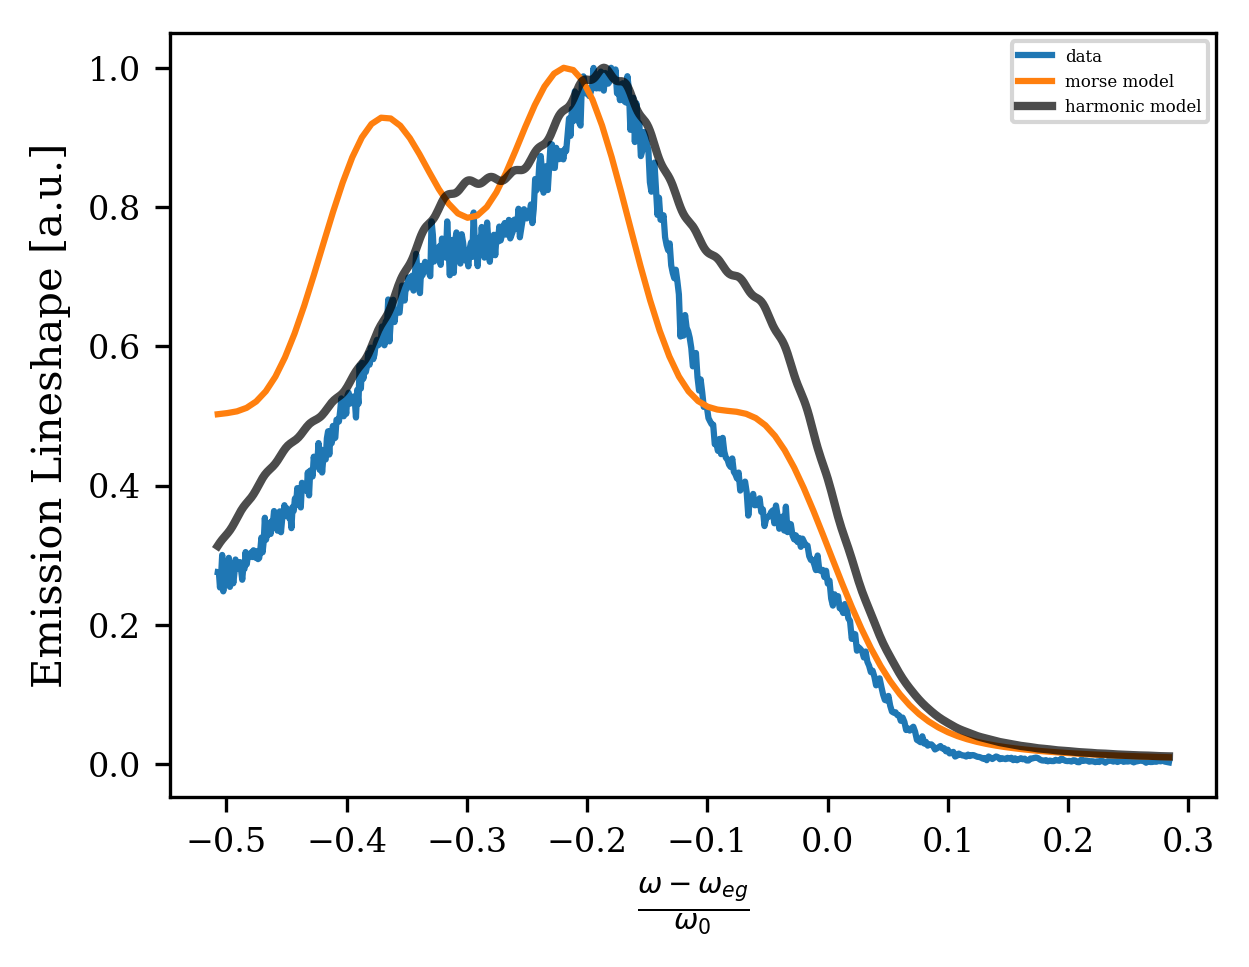

In [37]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

In [ ]:
alpha_test = 0.091 / 2
depth_test = 45
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [ ]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [ ]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

In [ ]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

In [ ]:
v

In [ ]:
alpha_test = 0.091/2
depth_test = 45*2
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [ ]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [ ]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

In [ ]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

In [48]:
alpha_test = 0.091
depth_test = 45*1.5
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [49]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [50]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

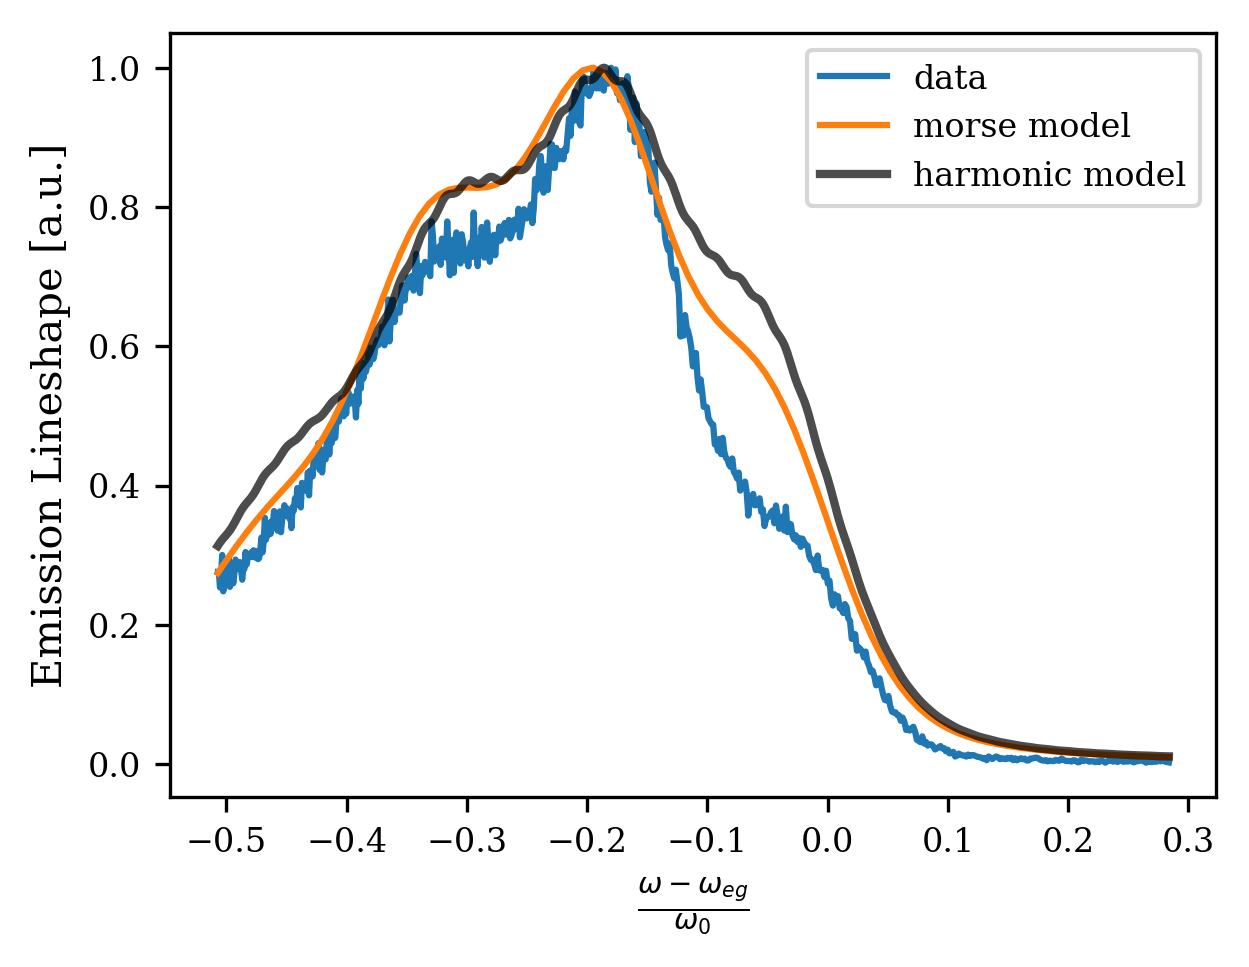

In [51]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=8)

In [52]:
alpha_test = 0.091/1.2
depth_test = 45*1.5
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [53]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [54]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

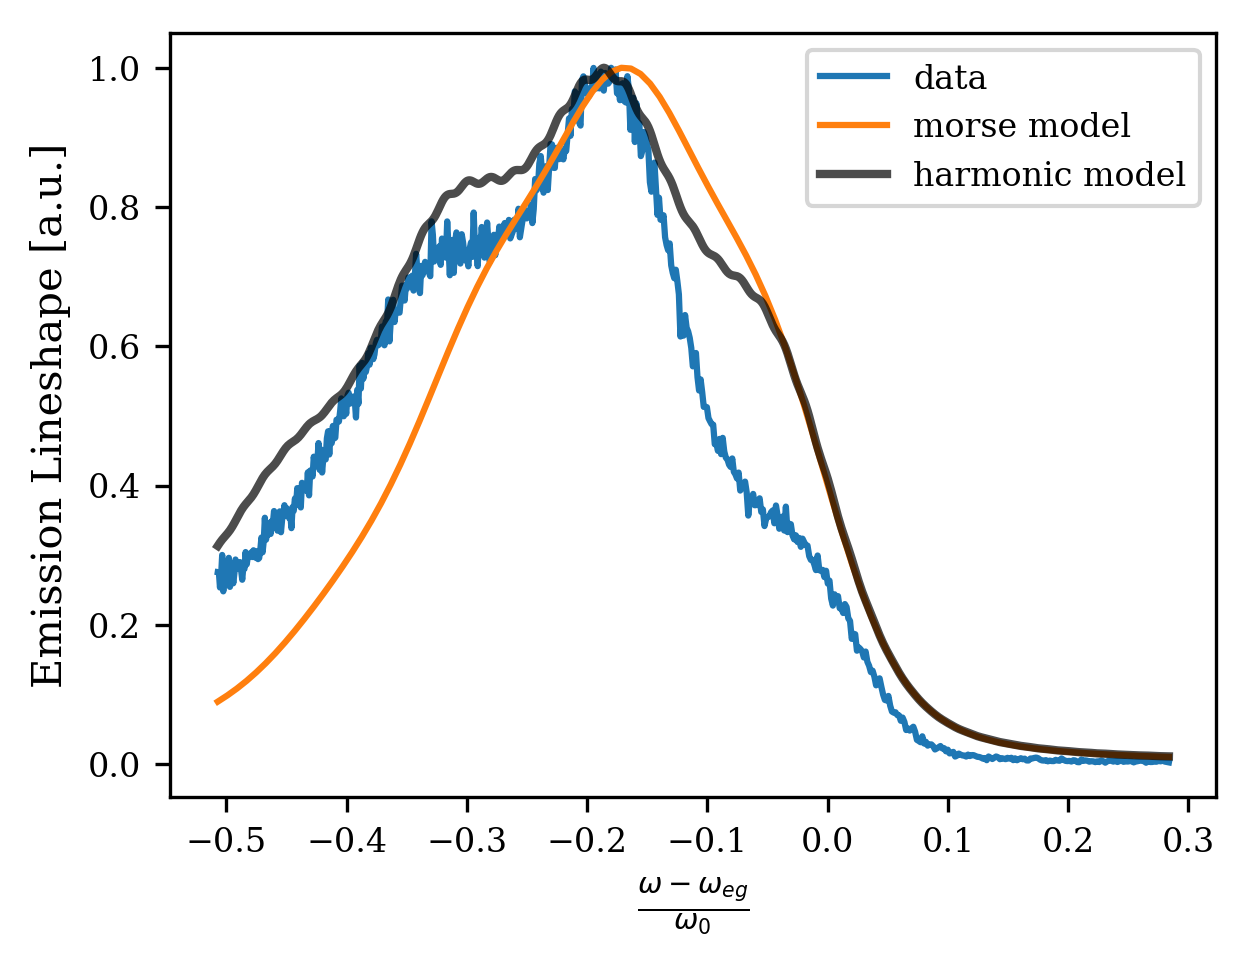

In [55]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=8)

In [56]:
alpha_test = 0.091/1.1
depth_test = 45*1.5
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [57]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [58]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

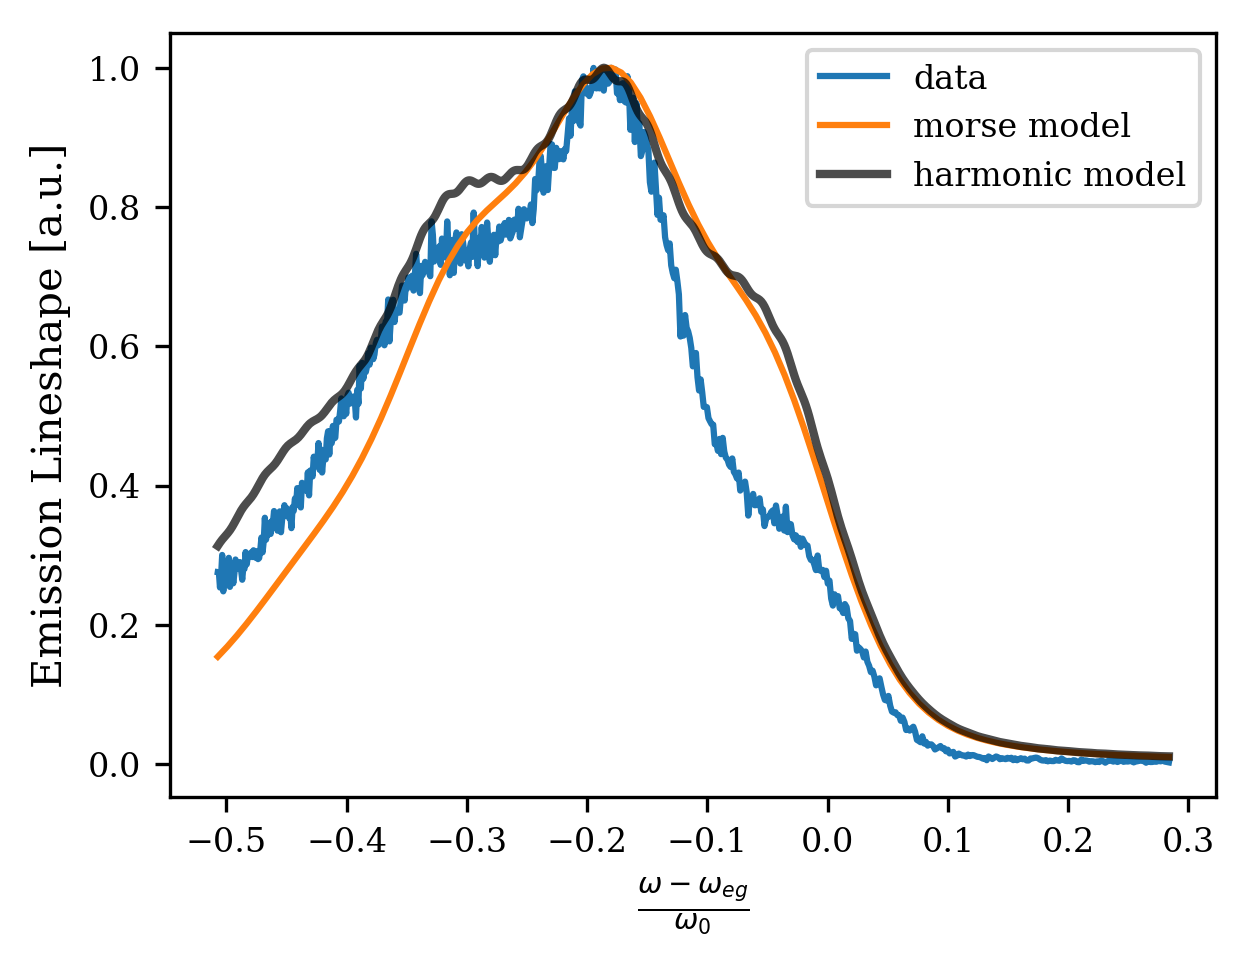

In [59]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=8)

In [61]:
alpha_test = 0.091/1.2
depth_test = 45*2
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [62]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [63]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

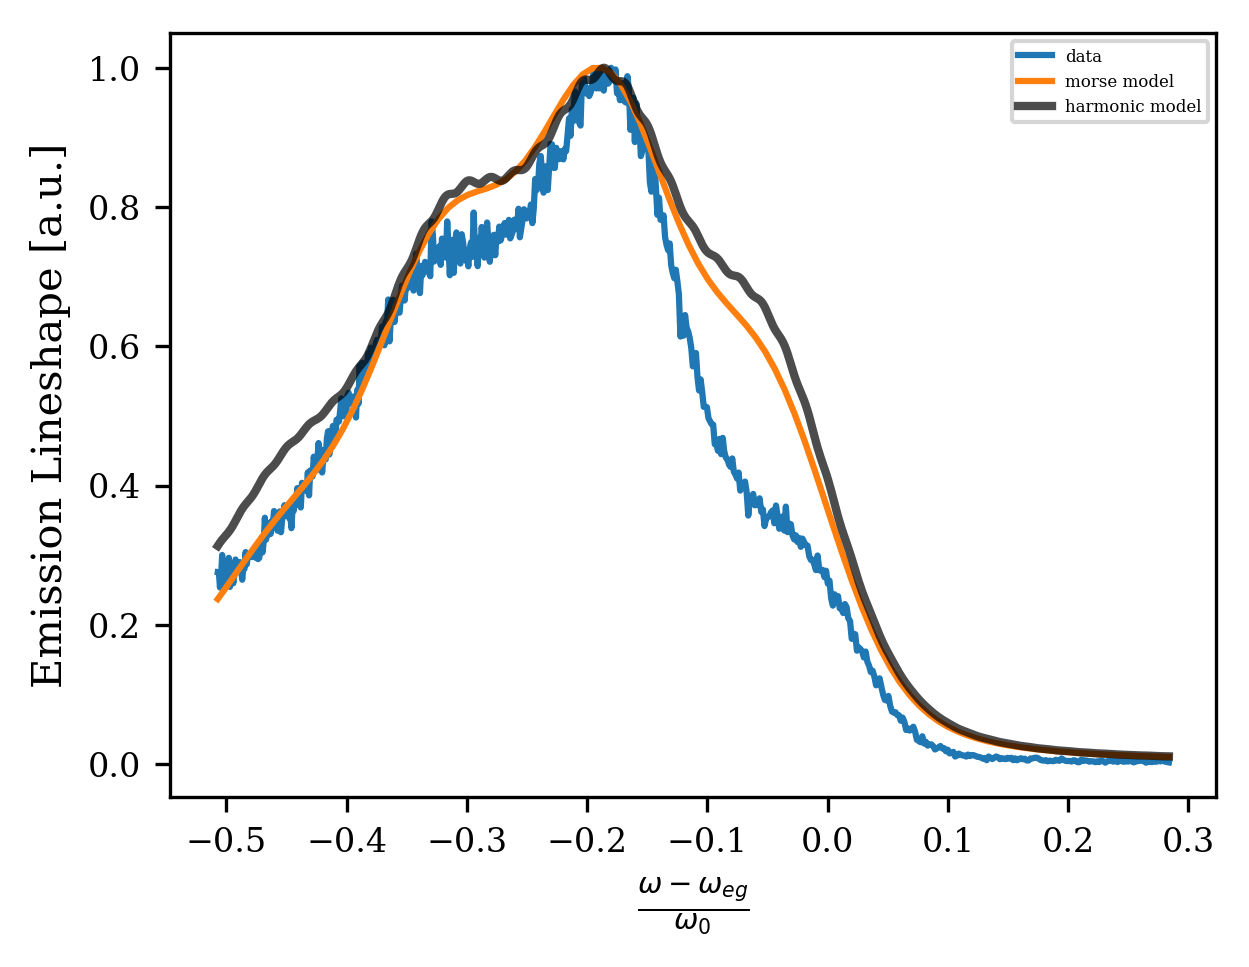

In [64]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

In [65]:
alpha_test = 0.091/1.5
depth_test = 45*2
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [66]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [67]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

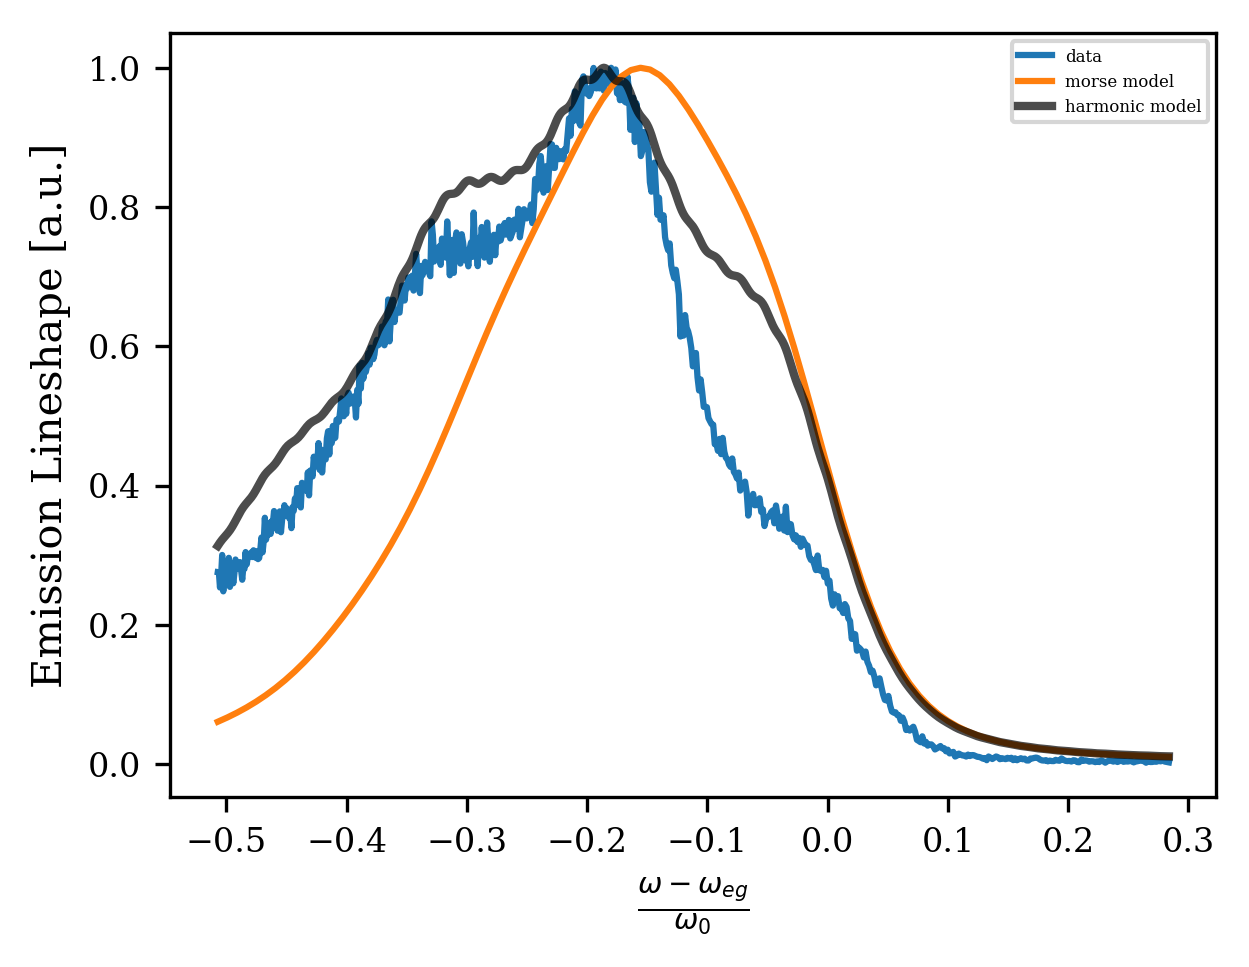

In [68]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)

In [69]:
alpha_test = 0.091/.9
depth_test = 45*1.5
basis_size

mm_lam_g_0 = lambda_generator_Morse(alpha_test, depth_test)
mm_lam_g_1 = np.zeros_like(mm_lam_g_0)

mm_lam_e_0 = dom.displaced_lambdas(mm_lam_g_0, ini_script_d[0])
mm_lam_e_1 = dom.displaced_lambdas(mm_lam_g_1, ini_script_d[1])

basis_size = 20

In [ ]:
mm_lam_g = np.vstack((mm_lam_g_0, mm_lam_g_1))
mm_lam_e = np.vstack((mm_lam_e_0, mm_lam_e_1))

multimode_test_inst = dom.multi_mode_anharmonic_emission(
    mm_lam_g,
    mm_lam_e,
    basis_size,
    hbar_omega_0=np.array([ini_hbar_omega_0[0], ini_hbar_omega_0[1]]),
    hbar_gamma=ini_hbar_gamma,
    T=T,
    integration_t_max=t_bound,
    integration_t_points=t_points,
    A_mat_order=7,
    )
    
# hw_domain = emily_data.T[0] - ini_hbar_omega_eg_0
# hw_domain = np.linspace(-5, 1, 30)
mm_lineshape = multimode_test_inst.emission_lineshape(
    hw_domain)

In [ ]:
mm_lineshape_m0 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=0)
mm_lineshape_m1 = multimode_test_inst.emission_lineshape(
    hw_domain,
    isolate_mode=1)

In [ ]:
plt.plot(emily_data.T[0]- ini_hbar_omega_eg_0, norm_spec(emily_data.T[1]), label='data')
plt.plot(hw_domain, norm_spec(mm_lineshape*2*np.pi/3), label='morse model')
# plt.plot(hbar_omegas_mor, mm_lineshape_m0, ls='--')
# plt.plot(hbar_omegas_mor, mm_lineshape_m1, ls='--')
plt.plot(emily_data.T[0] - ini_hbar_omega_eg_0, norm_spec(ini_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='harmonic model')
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.legend(fontsize=4)